# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 2 Naïve Bayes Classifier ##

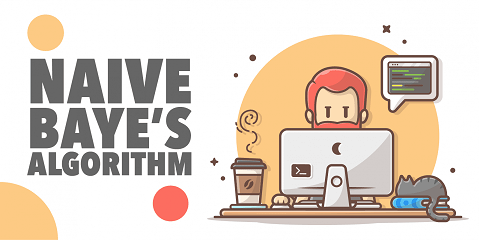

# Review

Before we start, let's have a quick recap of the lecture.
<br/><br/>

## Overview of Naïve Bayes
Using Bayes' Rule, we can calculate the probability of a <b>belief</b> given specific <b>evidence</b> (i.e., the posterior probability $P(B_i|E)$). \\

The belief with the highest posterior probability is the **prediction**. So, if we let $\hat{y}$ denote the prediction, then:

## $$ \hat{y} = argmax_{B_i} P(B_i|E) $$

<br />

Bayes' rule becomes **"Naïve Bayes"** if we assume each piece of evidence $e_j$ makes an independent and equal contribution to the belief $B_i$. Because of this assumption, we can calculate the posterior probability as:

<br />

$$P(B_i|E) = \frac{P(B_i)P(e_1|B_i)P(e_2|B_i)P(e_3|B_i)\ldots P(e_d|B_i)}{\sum_{j=1}^n P(e_1|B_j)P(e_2|B_j)P(e_3|B_j)\ldots P(e_d|B_j)P(B_j)}$$
<br/>

where $E = \{ e_1, e_2, e_3, \ldots, e_d\}$ is a set of evidence, $B_i$ is a belief.
<br/><br/>

Following Bayes' rule, a prediction can be made based on the belief with the highest posterior probability. If we are only interested in knowing **which belief** has the highest posterior probability value, then we no longer need to calculate the denominator (this remains the same for all beliefs). \\

So, the prediction can be made by maximizing the numerator with respect to $B_i$.

$$ \hat{y} = argmax_{B_i}P(B_i)P(e_1|B_i)P(e_2|B_i)P(e_3|B_i)\ldots P(e_d|B_i)$$
<br/><br/>




### Steps:

1. Compute the prior probability $P(B_i)$
2. Compute the likelihoods $P(e_j|B_i)$
3. Determine the belief with the highest posterior probability $\hat{y}$
4. Solve the zero probability problem with a smoothing term

# Example

We will use the following data samples to demonstrate how the Naïve Bayes is used to predict if a person (new sample) has a heart disease or not.

The set of evidence
$E = \{ restingBloodPressure,  serumCholesterol, diabetes, leftVentricularHypertrophy, STSlopeAnomaly, myocardialDefect \}$  
is used to diagnose the heart disease. Whether or not a person has a heart disease is represented as a binary variable $heartDisease$.

For simplicity, we use integers to represent each category of the evidence as shown below:

Column Name                            | Variable Type | Remarks
---------------------------------------|---------------|--------
restingBloodPressure                 | Categorical   | 0 = normal ; 1 = elevated ; 2 = hypertension
serumCholesterol                      | Categorical   | 0 = normal ; 1 = mild-risk ; 2 = high-risk
diabetes                               | Binary        | 0 = no ; 1 = yes
leftVentricularHypertrophy           | Binary        | 0 = no ; 1 = yes
STSlopeAnomaly                       | Binary        | 0 = no ; 1 = yes
myocardialDefect                      | Binary        | 0 = no ; 1 = yes
heartDisease                          | Binary        | 0 = no ; 1 = yes
<br/><br/>

There are 8 data samples for each case, which we will use to diagnose the new sample.

Dataset:
\begin{bmatrix}
    restingBloodPressure&serumCholesterol&diabetes&leftVentricularHypertrophy&STSlopeAnomaly&myocardialDefect&heartDisease \\
    0&1&0&0&1&0&0 \\
    1&1&0&0&1&0&0 \\
    1&0&0&0&1&0&0 \\
    0&1&0&0&0&0&0 \\
    2&2&0&1&1&0&1 \\
    1&2&0&0&1&1&1 \\
    2&2&0&1&0&1&1 \\
    1&1&0&0&0&1&1
\end{bmatrix}


New sample :
\begin{bmatrix}
    1&0&0&0&0&1
\end{bmatrix}

Target Label:
\begin{bmatrix}
    1
\end{bmatrix}

Here is the information in a numpy array:

In [ ]:
import numpy as np

X_train = np.array([[0, 1, 0, 0, 1, 0],
                    [1, 1, 0, 0, 1, 0],
                    [1, 0, 0, 0, 1, 0],
                    [0, 1, 0, 0, 0, 0],
                    [2, 2, 0, 1, 1, 0],
                    [1, 2, 0, 0, 1, 1],
                    [2, 2, 0, 1, 0, 1],
                    [1, 1, 0, 0, 0, 1]])

y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1])

X_test = np.array([[1, 0, 0, 0, 0, 1]])

y_test = np.array([1])

## Computing the prior probability

The prior probability is the probability of the belief $P(B_i)$. We can compute this using the values under the $heartDisease$ column.

$P(B = no)$ is the number of samples **without** heart disease divided by the total number of samples.

$P(B = yes)$ is the number of samples **with** heart disease divided by the total number of samples.



In [ ]:
P_no = np.sum(y_train == 0)/len(y_train)        # 4/8
P_yes = np.sum(y_train == 1)/len(y_train)       # 4/8

print('P_no is ' + str(P_no) + ' and P_yes is ' + str(P_yes))

P_no is 0.5 and P_yes is 0.5


How does this work?

* `y_train == 0` returns a boolean array: `[ True  True  True  True False False False False]`
* Applying `np.sum()` to a boolean array will count the number of `True` values in the array.
* We divide the sum by the total number of samples `len(y_train)`, which gives us the prior probability.

## Computing the likelihoods

The likelihood is the probability that a piece of **evidence** will happen if the **belief** is true.

For example, the probability that a person's $restingBloodPressure$ will be elevated if they have a heart disease $P(restingBloodPressure = 1|B = yes)$.

This can be calculated as follows:

##$P(restingBloodPressure = 1|B = yes) = \frac{\text{number of people with } \textbf{elevated } \text{resting blood pressure } \textbf{and heart disease}}{\text{number of people with heart disease}}$

<br />

If the dataset is large, we can use numpy operations to help us derive this value. How?
* First, we can get a boolean array for samples that have $restingBloodPressure = 1$
```
X_train[:, 0] == 1
```
* Then we can take its dot product with a boolean array for samples that have heart disease (i.e. `y_train == 1`):
```
np.dot(X_train[:, 0] == 1, (y_train == 1).astype(int))
```
* This gives us the numerator: 2.
* We can divide this by the number of people with heart disease, i.e. using `np.sum(y_train == 1)` to get 4,  to get the likelihood, which should be 0.5.

In [ ]:
resting_blood_pressure_elevated_yes = np.dot(X_train[:, 0] == 2, (y_train == 1).astype(int)) / np.sum(y_train == 1)
print('The likelihood value is '+ str(resting_blood_pressure_elevated_yes))

The likelihood value is 0.5



The rest of the likelihoods have been determined for you below:

In [ ]:
resting_blood_pressure_hypertension_yes = 2/4 # P(resting_blood_pressure = hypertension | heart_disease = yes)
resting_blood_pressure_elevated_yes = 2/4     # P(resting_blood_pressure = elevated | heart_disease = yes)
resting_blood_pressure_normal_yes = 0/4       # P(resting_blood_pressure = normal | heart_disease = yes)
resting_blood_pressure_hypertension_no = 0/4  # P(resting_blood_pressure = hypertension | heart_disease = no)
resting_blood_pressure_elevated_no = 2/4      # P(resting_blood_pressure = elevated | heart_disease = no)
resting_blood_pressure_normal_no = 2/4        # P(resting_blood_pressure = normal | heart_disease = no)

serum_cholesterol_highrisk_yes = 3/4          # P(serum_cholesterol = high-risk | heart_disease = yes)
serum_cholesterol_mildrisk_yes = 1/4          # P(serum_cholesterol = mild-risk | heart_disease = yes)
serum_cholesterol_normal_yes = 0/4            # P(serum_cholesterol = normal | heart_disease = yes)
serum_cholesterol_highrisk_no = 0/4           # P(serum_cholesterol = high-risk | heart_disease = no)
serum_cholesterol_mildrisk_no = 3/4           # P(serum_cholesterol = mild-risk | heart_disease = no)
serum_cholesterol_normal_no = 1/4             # P(serum_cholesterol = normal | heart_disease = no)

diabetes_yes_yes = 0/4                        # P(diabetes = yes | heart_disease = yes)
diabetes_no_yes = 4/4                         # P(diabetes = no | heart_disease = yes)
diabetes_yes_no = 0/4                         # P(diabetes = yes | heart_disease = no)
diabetes_no_no = 4/4                          # P(diabetes = no | heart_disease = no)

left_ventricular_hypertrophy_yes_yes = 2/4    # P(left_ventricular_hypertrophy = yes | heart_disease = yes)
left_ventricular_hypertrophy_no_yes = 2/4     # P(left_ventricular_hypertrophy = no | heart_disease = yes)
left_ventricular_hypertrophy_yes_no = 0/4     # P(left_ventricular_hypertrophy = yes | heart_disease = no)
left_ventricular_hypertrophy_no_no = 4/4      # P(left_ventricular_hypertrophy = no | heart_disease = no)

ST_slope_anomaly_yes_yes = 2/4                # P(ST_slope_anomaly = yes | heart_disease = yes)
ST_slope_anomaly_no_yes = 2/4                 # P(ST_slope_anomaly = no | heart_disease = yes)
ST_slope_anomaly_yes_no = 3/4                 # P(ST_slope_anomaly = yes | heart_disease = no)
ST_slope_anomaly_no_no = 1/4                  # P(ST_slope_anomaly = no | heart_disease = no)

myocardial_defect_yes_yes = 3/4               # P(myocardial_defect = yes | heart_disease = yes)
myocardial_defect_no_yes = 1/4                # P(myocardial_defect = no | heart_disease = yes)
myocardial_defect_yes_no = 0/4                # P(myocardial_defect = yes | heart_disease = no)
myocardial_defect_no_no = 4/4                 # P(myocardial_defect = no | heart_disease = no)

## Making the prediction $\hat{y}$

To recap, this is how we predict $\hat{y}$

## $$\hat{y} = argmax_{B_i}P(B_i)P(e_1|B_i)P(e_2|B_i)P(e_3|B_i)\ldots P(e_d|B_i)$$
<br />
### Preventing underflow

Multiplying lots of probabilities between 0 and 1 can result in floating-point underflow.

It is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. So the prediction can be based on:

## $$\hat{y} = argmax_{B_i} \left( \log P(B_i) + \sum_{n=1}^d \log P(e_n|B_i) \right)$$

We can now use the prior probabilities and likelihoods that we computed to make a prediction for the new sample.

In [ ]:
# for new sample 1 0 0 0 0 1
log_P_yes = np.log(P_yes) + \
        np.log(resting_blood_pressure_elevated_yes) + \
        np.log(serum_cholesterol_normal_yes) + \
        np.log(diabetes_no_yes) + \
        np.log(left_ventricular_hypertrophy_no_yes) + \
        np.log(ST_slope_anomaly_no_yes) + \
        np.log(myocardial_defect_yes_yes)

log_P_no = np.log(P_no) + \
       np.log(resting_blood_pressure_elevated_no) + \
       np.log(serum_cholesterol_normal_no) + \
       np.log(diabetes_no_no) + \
       np.log(left_ventricular_hypertrophy_no_no) + \
       np.log(ST_slope_anomaly_no_no) + \
       np.log(myocardial_defect_yes_no)

<ipython-input-5-d34f173f45cc>:4: RuntimeWarning: divide by zero encountered in log
  np.log(serum_cholesterol_normal_yes) + \
<ipython-input-5-d34f173f45cc>:16: RuntimeWarning: divide by zero encountered in log
  np.log(myocardial_defect_yes_no)


As you case see, there is an error: **RuntimeWarning: divide by zero encountered in log** \\

This is because some of the likelihood values are 0:


```
resting_blood_pressure_normal_yes = 0/4       # P(resting_blood_pressure = normal | heart_disease = yes)
resting_blood_pressure_hypertension_no = 0/4  # P(resting_blood_pressure = hypertension | heart_disease = no)
serum_cholesterol_normal_yes = 0/4            # P(serum_cholesterol = normal | heart_disease = yes)
serum_cholesterol_highrisk_no = 0/4           # P(serum_cholesterol = high-risk | heart_disease = no)
diabetes_yes_yes = 0/4                        # P(diabetes = yes | heart_disease = yes)
diabetes_yes_no = 0/4                         # P(diabetes = yes | heart_disease = no)

```



## Solving the zero probability problem with a <b>smoothing term ($\alpha$)</b>

As you can see, the above code cell will raise the **RuntimeWarning of "divide by zero encountered in log"**. That is because some combinations of evidence and beliefs cannot be found in the observations.

For example, **resting_blood_pressure = normal & heart_disease = yes** does not occur in the training set, so the count is 0. This means that the likelihood probability is also 0, which results in the ill-defined log probability because $\log 0$ is not well defined.

**To avoid the zero probability problem**, a practical solution is to **add a value to each piece of evidence**. This value is called a **smoothing term**. The smoothing term affects the calculation of probability values. For example, the prior calculation with the smoothing term is:

###$P(myocardialDefect = 1\text{(yes)}|B = yes) = \frac{3 \text{ people with myocardial defect AND heart disease } + \alpha }{4 \text{ people with heart disease } + \alpha\text{(number of feature categories)} }$

In the specific case where the smoothing term is 1, the use of a smoothing term is called the **Add-one-count trick**.
<br /><br />

The **add-one-count trick** is a widely-used trick in real-world applications to avoid 0 probability, especially for sparse data.
The extra 1 count is called smoothing term. The smoothing term does not necessarily be 1. People sometimes treat it as a model parameter and tune the smoothing term to find the best performance of the model.




### Example: Application of add-one-count trick to likelihoods

(Let's abbreviate resting blood pressure to RBP for the following example)

<br />

###$P(restingBloodPressure = 1\text{(elevated)}|B = yes) = \frac{2 \text{ people with elevated RBP AND heart disease + 1}}{4 \text{ people with heart disease + 1 "extra" person with hypertension RBP + 1 "extra" person with elevated RBP + 1 "extra" person with normal RBP }}$

$ = 3/7 $

<br />

###$P(myocardialDefect = 1\text{(yes)}|B = yes) = \frac{3 \text{ people with myocardial defect AND heart disease + 1 }}{4 \text{ people with heart disease + 1 "extra" person } \textbf{without} \text{ myocardial defect + 1 "extra" person } \textbf{with} \text{ myocardial defect}}$

$ = 4/6 $

In [ ]:
resting_blood_pressure_hypertension_yes = 3/7 # P(resting_blood_pressure = hypertension | heart_disease = yes)
resting_blood_pressure_elevated_yes = 3/7     # P(resting_blood_pressure = elevated | heart_disease = yes)
resting_blood_pressure_normal_yes = 1/7       # P(resting_blood_pressure = normal | heart_disease = yes)
resting_blood_pressure_hypertension_no = 1/7  # P(resting_blood_pressure = hypertension | heart_disease = no)
resting_blood_pressure_elevated_no = 3/7      # P(resting_blood_pressure = elevated | heart_disease = no)
resting_blood_pressure_normal_no = 3/7        # P(resting_blood_pressure = normal | heart_disease = no)

serum_cholesterol_highrisk_yes = 4/7          # P(serum_cholesterol = high-risk | heart_disease = yes)
serum_cholesterol_mildrisk_yes = 2/7          # P(serum_cholesterol = mild-risk | heart_disease = yes)
serum_cholesterol_normal_yes = 1/7            # P(serum_cholesterol = normal | heart_disease = yes)
serum_cholesterol_highrisk_no = 1/7           # P(serum_cholesterol = high-risk | heart_disease = no)
serum_cholesterol_mildrisk_no = 4/7           # P(serum_cholesterol = mild-risk | heart_disease = no)
serum_cholesterol_normal_no = 2/7             # P(serum_cholesterol = normal | heart_disease = no)

diabetes_yes_yes = 1/6                        # P(diabetes = yes | heart_disease = yes)
diabetes_no_yes = 5/6                         # P(diabetes = no | heart_disease = yes)
diabetes_yes_no = 1/6                         # P(diabetes = yes | heart_disease = no)
diabetes_no_no = 5/6                          # P(diabetes = no | heart_disease = no)

left_ventricular_hypertrophy_yes_yes = 3/6    # P(left_ventricular_hypertrophy = yes | heart_disease = yes)
left_ventricular_hypertrophy_no_yes = 3/6     # P(left_ventricular_hypertrophy = no | heart_disease = yes)
left_ventricular_hypertrophy_yes_no = 1/6     # P(left_ventricular_hypertrophy = yes | heart_disease = no)
left_ventricular_hypertrophy_no_no = 5/6      # P(left_ventricular_hypertrophy = no | heart_disease = no)

ST_slope_anomaly_yes_yes = 3/6                # P(ST_slope_anomaly = yes | heart_disease = yes)
ST_slope_anomaly_no_yes = 3/6                 # P(ST_slope_anomaly = no | heart_disease = yes)
ST_slope_anomaly_yes_no = 4/6                 # P(ST_slope_anomaly = yes | heart_disease = no)
ST_slope_anomaly_no_no = 2/6                  # P(ST_slope_anomaly = no | heart_disease = no)

myocardial_defect_yes_yes = 4/6               # P(myocardial_defect = yes | heart_disease = yes)
myocardial_defect_no_yes = 2/6                # P(myocardial_defect = no | heart_disease = yes)
myocardial_defect_yes_no = 1/6                # P(myocardial_defect = yes | heart_disease = no)
myocardial_defect_no_no = 5/6                 # P(myocardial_defect = no | heart_disease = no)



# for 1 0 0 0 0 1
log_P_yes = np.log(P_yes) + \
        np.log(resting_blood_pressure_elevated_yes) + \
        np.log(serum_cholesterol_normal_yes) + \
        np.log(diabetes_no_yes) + \
        np.log(left_ventricular_hypertrophy_no_yes) + \
        np.log(ST_slope_anomaly_no_yes) + \
        np.log(myocardial_defect_yes_yes)

log_P_no = np.log(P_no) + \
       np.log(resting_blood_pressure_elevated_no) + \
       np.log(serum_cholesterol_normal_no) + \
       np.log(diabetes_no_no) + \
       np.log(left_ventricular_hypertrophy_no_no) + \
       np.log(ST_slope_anomaly_no_no) + \
       np.log(myocardial_defect_yes_no)

print(f"The log probability of the new samples being heart disease is {log_P_yes}.")
print(f"The log probability of the new samples not being heart disease is {log_P_no}.")

print()
print("We predict that the new sample has heart disease.")

The log probability of the new samples being heart disease is -5.460436216024472.
The log probability of the new samples not being heart disease is -6.048222880926591.

We predict that the new sample has heart disease.


# Some final notes

* The assumption made by Naïve Bayes is <font color="red">NOT</font>  correct in most real-world situations. The independence assumption is an oversimplification but often works well in practice.
* It is tedious to write code for each likelihood value such as:
```
np.dot(X_train[:, 0] == 2, (y_train == 1).astype(int)) / np.sum(y_train == 1)
```
* The lab activity requires you to do this <font color="blue">efficiently</font> using vectorization.
* The lab activity also requires you to make a general Naïve Bayes model that works well with any dataset (e.g. different features, different number of classes). So, you cannot specify `X_train[:, 0] == 2` or `y_train == 1`.
